In [105]:
# Import Libraries
import os
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, box
import fiona
import pandas as pd
import geopandas as gpd
import rasterio as rio
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [2]:
# Source data, SRTM & GLIHT
srtm_source = os.path.join('/Users/arbailey/natcap/idb/data/source/srtm/nasa','SRTM30m_Andros.vrt')
glihtdtm_source = os.path.join('/Users/arbailey/natcap/idb/data/source/gliht/Andros_May2015/lidar/geotiff/Andros_May2015_DTM','Andros_May2015_DTM.vrt')
glihtchm_source = os.path.join('/Users/arbailey/natcap/idb/data/source/gliht/Andros_May2015/lidar/geotiff/Andros_May2015_CHM','Andros_May2015_CHM.vrt' )
# Working directory
work_dir = '/Users/arbailey/natcap/idb/data/work/andros_mangrovehgt'
os.chdir(work_dir)

In [3]:
def get_valid_indices(msked_array):
    # Return tuples of indices for valid (unmasked) values in a masked array
    rows, cols = np.where(~msked_array.mask)
    indices = list(zip(rows, cols))
    return indices

In [4]:
# Read GLiHT data into a masked numpy array
glihtchm = rio.open(glihtchm_source) # Rasterio Data source
glihtchm_np = glihtchm.read(1, masked=True) # as NumPy masked array

# Cell indices for valid values in the DSM
indices = get_valid_indices(glihtchm_np)
# Initiate arrays to store x,y,z values from raster
x_coords = []
y_coords = []
vals = []
# Get x,y coords in projection and associated value
for row, col in indices:
    x, y = glihtchm.xy(row, col)
    val = glihtchm_np[row][col]
    x_coords.append(x)
    y_coords.append(y)
    vals.append(val)
     
print(x_coords[250], y_coords[250], vals[250])

788768.5 2787842.5 0.0


In [5]:
# Create Pandas Data Frame with GLiHT 
# The data as a set of parallel lists
glihtchm_xyz = {
    'z_m':vals,
    'x_utm17n': x_coords,
    'y_utm17n': y_coords
}
glihtchm_df = pd.DataFrame(glihtchm_xyz)
print(glihtchm_df.head)

<bound method NDFrame.head of           z_m  x_utm17n   y_utm17n
0         0.0  788785.5  2787858.5
1         0.0  788781.5  2787857.5
2         0.0  788784.5  2787857.5
3         0.0  788776.5  2787856.5
4         0.0  788778.5  2787856.5
...       ...       ...        ...
58146866  0.0  802646.5  2691223.5
58146867  0.0  802641.5  2691222.5
58146868  0.0  802644.5  2691221.5
58146869  0.0  802646.5  2691220.5
58146870  0.0  802650.5  2691218.5

[58146871 rows x 3 columns]>


In [6]:
# Create Geopandas data frame with point locations from Pandas data frame
glihtchm_gdf = gpd.GeoDataFrame(glihtchm_df, geometry=gpd.points_from_xy(glihtchm_df['x_utm17n'], glihtchm_df['y_utm17n']))
print(glihtchm_gdf.head)

<bound method NDFrame.head of           z_m  x_utm17n   y_utm17n                        geometry
0         0.0  788785.5  2787858.5  POINT (788785.500 2787858.500)
1         0.0  788781.5  2787857.5  POINT (788781.500 2787857.500)
2         0.0  788784.5  2787857.5  POINT (788784.500 2787857.500)
3         0.0  788776.5  2787856.5  POINT (788776.500 2787856.500)
4         0.0  788778.5  2787856.5  POINT (788778.500 2787856.500)
...       ...       ...        ...                             ...
58146866  0.0  802646.5  2691223.5  POINT (802646.500 2691223.500)
58146867  0.0  802641.5  2691222.5  POINT (802641.500 2691222.500)
58146868  0.0  802644.5  2691221.5  POINT (802644.500 2691221.500)
58146869  0.0  802646.5  2691220.5  POINT (802646.500 2691220.500)
58146870  0.0  802650.5  2691218.5  POINT (802650.500 2691218.500)

[58146871 rows x 4 columns]>


In [7]:
# Get CRS from GLiHT and convert it to right format to assign to CRS of GeoData Frame
print(glihtchm.meta['crs'])
gliht_epsg = glihtchm.meta['crs'].to_epsg()
glihtchm_gdf.crs = fiona.crs.from_epsg(gliht_epsg)
print(glihtchm_gdf.crs)

EPSG:32617
{'init': 'epsg:32617', 'no_defs': True}


In [8]:
# Import SRTM Data
srtm = rio.open(srtm_source) # as rasterio dataset
srtm_np = srtm.read(1, masked=True)  # Read to 2D masked NumPy Array
srtm_epsg = srtm.crs.to_epsg()
print(srtm_epsg)

4326


In [9]:
# Reproject GLiHT points to SRTM CRS
glihtchm_gdf_srtmcrs = glihtchm_gdf.to_crs(epsg=srtm_epsg)

In [10]:
def point_coords(geom):
    # Return a tuple with the x/y point coordinate for a GeoDataFrame geometry
    # return list(geom.coords)
    return list(geom.coords)[0] # Just get first tuple in list, since it's a point
# Get Lat/Long coordinates from GDF's geometry
glihtchm_ll = glihtchm_gdf_srtmcrs.apply(lambda row: point_coords(row.geometry), axis=1)

In [11]:
# Sample SRTM raster with the GLiHT points (creates generator)
srtm_sample_gen = srtm.sample(xy=glihtchm_ll)
# Copy original GLiHT Geodataframe to new one for modification
glihtchm_srtm_gdf = glihtchm_gdf_srtmcrs.copy()
# Convert generator to a list for appending to geodataframe
srtm_sample = list(srtm_sample_gen)
# Append sampled SRTM values to Geodataframe
glihtchm_srtm_gdf['srtm_m'] = np.vstack(srtm_sample)
print(glihtchm_srtm_gdf.head())
print(glihtchm_srtm_gdf.describe())

   z_m  x_utm17n   y_utm17n                    geometry  srtm_m
0  0.0  788785.5  2787858.5  POINT (-78.13478 25.17915)       0
1  0.0  788781.5  2787857.5  POINT (-78.13482 25.17914)       0
2  0.0  788784.5  2787857.5  POINT (-78.13479 25.17914)       0
3  0.0  788776.5  2787856.5  POINT (-78.13487 25.17913)       0
4  0.0  788778.5  2787856.5  POINT (-78.13485 25.17913)       0
                z_m      x_utm17n      y_utm17n        srtm_m
count  5.814687e+07  5.814687e+07  5.814687e+07  5.814687e+07
mean   3.234375e+00  8.087125e+05  2.731477e+06  6.902376e+00
std    5.033649e+00  8.274789e+03  2.413671e+04  4.414268e+00
min   -1.818989e-12  7.885925e+05  2.691218e+06 -1.400000e+01
25%    0.000000e+00  8.029605e+05  2.712500e+06  4.000000e+00
50%    0.000000e+00  8.092105e+05  2.727656e+06  6.000000e+00
75%    5.220000e+00  8.157185e+05  2.745886e+06  1.000000e+01
max    2.471000e+01  8.230035e+05  2.787858e+06  4.200000e+01


In [76]:
# Create an array with unique ID for each SRTM pixel
with rio.open(srtm_source) as src:
    rows, cols = src.shape
    srtm_uniqueid_np = np.arange(rows * cols).reshape(rows, cols) + 1 # want to start at 1 and not zero for ids
srtm_uniqueid_np = srtm_uniqueid_np.astype('uint32')
srtm_uniqueid_np.dtype
srtm_uniqueid_np

array([[       1,        2,        3, ...,     7199,     7200,     7201],
       [    7202,     7203,     7204, ...,    14400,    14401,    14402],
       [   14403,    14404,    14405, ...,    21601,    21602,    21603],
       ...,
       [77756399, 77756400, 77756401, ..., 77763597, 77763598, 77763599],
       [77763600, 77763601, 77763602, ..., 77770798, 77770799, 77770800],
       [77770801, 77770802, 77770803, ..., 77777999, 77778000, 77778001]],
      dtype=uint32)

In [46]:
# Get metadata from SRTM and apply to SRTM unique ID raster
srtm_uniqueid_meta = srtm.meta
print(srtm_uniqueid_meta)
srtm_uniqueid_meta['dtype'] = rio.uint32 # change data type to hold all values
srtm_uniqueid_meta['nodata'] = 0 # No data value
srtm_uniqueid_meta['driver'] = 'GTiff'
print(srtm_uniqueid_meta)

{'driver': 'VRT', 'dtype': 'int16', 'nodata': -32768.0, 'width': 7201, 'height': 10801, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.0002777777777777778, 0.0, -79.00013888888888,
       0.0, -0.0002777777777777778, 26.000138888888888)}
{'driver': 'GTiff', 'dtype': 'uint32', 'nodata': 0, 'width': 7201, 'height': 10801, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.0002777777777777778, 0.0, -79.00013888888888,
       0.0, -0.0002777777777777778, 26.000138888888888)}


In [49]:
# Convert SRTM unique to a Raster 
SRTM_uniqueid_source = 'SRTM30m_Andros_uniqueid.tif'
with rio.open(SRTM_uniqueid_source, 'w', **srtm_uniqueid_meta) as dst:
    dst.write(srtm_uniqueid_np, 1)
srtm_uniqueid = rio.open(SRTM_uniqueid_source, 'r')
print(type(srtm_uniqueid))

<class 'rasterio.io.DatasetReader'>


In [50]:
# Sample SRTM unique ID raster with the GLiHT points 
sample_gen = srtm_uniqueid.sample(xy=glihtchm_ll)
# Convert generator to a list for appending to geodataframe
srtmid_sample = list(sample_gen)
# Append sampled SRTM values to Geodataframe
glihtchm_srtm_gdf['srtm_id'] = np.vstack(srtmid_sample)
print(glihtchm_srtm_gdf.head())
print(glihtchm_srtm_gdf.describe())

   z_m  x_utm17n   y_utm17n                    geometry  srtm_m   srtm_id
0  0.0  788785.5  2787858.5  POINT (-78.13478 25.17915)       0  21282071
1  0.0  788781.5  2787857.5  POINT (-78.13482 25.17914)       0  21282071
2  0.0  788784.5  2787857.5  POINT (-78.13479 25.17914)       0  21282071
3  0.0  788776.5  2787856.5  POINT (-78.13487 25.17913)       0  21282070
4  0.0  788778.5  2787856.5  POINT (-78.13485 25.17913)       0  21282071
                z_m      x_utm17n      y_utm17n        srtm_m       srtm_id
count  5.814687e+07  5.814687e+07  5.814687e+07  5.814687e+07  5.814687e+07
mean   3.234375e+00  8.087125e+05  2.731477e+06  6.902376e+00  3.456760e+07
std    5.033649e+00  8.274789e+03  2.413671e+04  4.414268e+00  5.650776e+06
min   -1.818989e-12  7.885925e+05  2.691218e+06 -1.400000e+01  2.128207e+07
25%    0.000000e+00  8.029605e+05  2.712500e+06  4.000000e+00  3.122754e+07
50%    0.000000e+00  8.092105e+05  2.727656e+06  6.000000e+00  3.549756e+07
75%    5.220000e+00  8.1

### Sampling of all the Andros mangrove layers with the GLiHT CHM points

In [79]:
# Directories and data of mangrove layers to be sampled
mangroves_dir = '/Users/arbailey/natcap/idb/data/work/mangroves'
mangroves_gpkg = os.path.join(mangroves_dir, 'mangroves_andros.gpkg')
# Simard - Mangrove Height
mangrovehgt_tif = 'Mangrove_hmax95_andros.tif'
mangrovehgt_source = os.path.join(mangroves_dir, mangrovehgt_tif)
# Giri - Global Mangrove Forest
gmf_lyr = 'gmf_andros'
# Spalding - World Atlas of Mangroves
wam_lyr = 'wam2010_andros_droppedfields'
# Bunting - Global Mangrove Watch
gmw19962016_lyr = 'gmw_1996_2016_andros'
gmw2015_lyr = 'GMW_2015_v2_andros'

In [80]:
# Read in the mangrove height raster
mangrovehgt = rio.open(mangrovehgt_source)

# Create an array with unique ID for each mangrove height pixel
with rio.open(mangrovehgt_source) as src:
    rows, cols = src.shape
    mh_uniqueid_np = np.arange(rows * cols).reshape(rows, cols) + 1 # want to start at 1 and not zero for ids
mh_uniqueid_np = srtm_uniqueid_np.astype('uint32')

# Get metadata from mangrove height raster and apply to mangrove height unique ID raster
mh_uniqueid_meta = mangrovehgt.meta
print(mh_uniqueid_meta)
mh_uniqueid_meta['dtype'] = rio.uint32 # change data type to hold all values
mh_uniqueid_meta['nodata'] = 0 # No data value
mh_uniqueid_meta['driver'] = 'GTiff'
print(mh_uniqueid_meta)

# Convert mangrove height unique id to a Raster 
mh_uniqueid_source = 'Mangrove_hmax95_andros_uniqueid.tif'
with rio.open(mh_uniqueid_source, 'w', **mh_uniqueid_meta) as dst:
    dst.write(mh_uniqueid_np, 1)
mh_uniqueid = rio.open(mh_uniqueid_source, 'r')
print(type(mh_uniqueid))

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -3.4e+38, 'width': 6728, 'height': 8145, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.0002777777777628616, 0.0, -78.77425441376981,
       0.0, -0.0002777777777732296, 25.59266586403205)}
{'driver': 'GTiff', 'dtype': 'uint32', 'nodata': 0, 'width': 6728, 'height': 8145, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.0002777777777628616, 0.0, -78.77425441376981,
       0.0, -0.0002777777777732296, 25.59266586403205)}
<class 'rasterio.io.DatasetReader'>


In [82]:
# Sample the Mangrove Height rasters
sample_gen = mangrovehgt.sample(xy=glihtchm_ll)
# Convert generator to a list for appending to geodataframe
sample = list(sample_gen)
# Append sampled values to Geodataframe
glihtchm_srtm_gdf['hmax95'] = np.vstack(sample)
print(glihtchm_srtm_gdf.head())
print(glihtchm_srtm_gdf.describe())

# Sample the Mangrove Height Unique ID rasters
sample_gen = mh_uniqueid.sample(xy=glihtchm_ll)
# Convert generator to a list for appending to geodataframe
sample = list(sample_gen)
# Append sampled values to Geodataframe
glihtchm_srtm_gdf['hmax95_id'] = np.vstack(sample)
print(glihtchm_srtm_gdf.head())
print(glihtchm_srtm_gdf.describe())

   z_m  x_utm17n   y_utm17n                    geometry  srtm_m   srtm_id  \
0  0.0  788785.5  2787858.5  POINT (-78.13478 25.17915)       0  21282071   
1  0.0  788781.5  2787857.5  POINT (-78.13482 25.17914)       0  21282071   
2  0.0  788784.5  2787857.5  POINT (-78.13479 25.17914)       0  21282071   
3  0.0  788776.5  2787856.5  POINT (-78.13487 25.17913)       0  21282070   
4  0.0  788778.5  2787856.5  POINT (-78.13485 25.17913)       0  21282071   

         hmax95  
0 -3.400000e+38  
1 -3.400000e+38  
2 -3.400000e+38  
3 -3.400000e+38  
4 -3.400000e+38  
                z_m      x_utm17n      y_utm17n        srtm_m       srtm_id  \
count  5.814687e+07  5.814687e+07  5.814687e+07  5.814687e+07  5.814687e+07   
mean   3.234375e+00  8.087125e+05  2.731477e+06  6.902376e+00  3.456760e+07   
std    5.033649e+00  8.274789e+03  2.413671e+04  4.414268e+00  5.650776e+06   
min   -1.818989e-12  7.885925e+05  2.691218e+06 -1.400000e+01  2.128207e+07   
25%    0.000000e+00  8.029605e+05 

In [215]:
# export to Geopackage
glihtchm_srtm_gdf.to_file("gliht_srtm.gpkg", layer='glihtchm_srtm_hmax95', driver="GPKG")

In [84]:
# Load mangrove polygon layers
gmf = gpd.read_file(mangroves_gpkg, layer=gmf_lyr) # Giri, Global Mangrove Forests
wam = gpd.read_file(mangroves_gpkg, layer=wam_lyr) # Spalding, World Atlas of Mangroves
gmw19962016 = gpd.read_file(mangroves_gpkg, layer=gmw19962016_lyr)  # Bunting, Global Mangrove Watch - all years
gmw2015 = gpd.read_file(mangroves_gpkg, layer=gmw2015_lyr) # Bunting, Global Mangrove Watch 2015

In [86]:
print(gmf.head)
print(wam.head)
print(gmw19962016.head)
print(gmw2015.head)

<bound method NDFrame.head of       gmf                                           geometry
0       1  MULTIPOLYGON (((-77.72648 25.58740, -77.72594 ...
1       1  MULTIPOLYGON (((-77.72594 25.58713, -77.72567 ...
2       1  MULTIPOLYGON (((-77.72376 25.57758, -77.72321 ...
3       1  MULTIPOLYGON (((-77.72294 25.57567, -77.72267 ...
4       1  MULTIPOLYGON (((-77.72321 25.57349, -77.72267 ...
...   ...                                                ...
4741    1  MULTIPOLYGON (((-77.69321 23.69467, -77.69267 ...
4742    1  MULTIPOLYGON (((-77.38203 23.68758, -77.38148 ...
4743    1  MULTIPOLYGON (((-77.69294 23.68622, -77.69267 ...
4744    1  MULTIPOLYGON (((-77.75976 23.68076, -77.75921 ...
4745    1  MULTIPOLYGON (((-77.75921 23.68022, -77.75867 ...

[4746 rows x 2 columns]>
<bound method NDFrame.head of    wam                                           geometry
0    1  MULTIPOLYGON (((-77.49059 23.90124, -77.49017 ...
1    1  MULTIPOLYGON (((-77.79057 24.34241, -77.79251 ...
2    1  

In [87]:
gmw2015_att = 'gmw2015'
gmw2015 = gmw2015.rename(columns={'pxlval': gmw2015_att})
gmw2015 = gmw2015[[gmw2015_att,'geometry']]
gmw2015[gmw2015_att] = pd.to_numeric(gmw2015[gmw2015_att], downcast='integer')
gmw2015

,gmw2015,geometry
0,1,"POLYGON ((-77.74444 24.00000, -77.74422 24.000..."
1,1,"POLYGON ((-77.74400 24.00000, -77.74378 24.000..."
2,1,"POLYGON ((-77.75267 23.99978, -77.75244 23.999..."
3,1,"POLYGON ((-77.74711 24.00000, -77.74578 24.000..."
4,1,"POLYGON ((-77.74511 23.99956, -77.74467 23.999..."
...,...,...
9704,1,"POLYGON ((-77.81733 24.00156, -77.81711 24.001..."
9705,1,"POLYGON ((-77.74756 24.00089, -77.74689 24.000..."
9706,1,"POLYGON ((-77.76933 24.00089, -77.76911 24.000..."
9707,1,"POLYGON ((-77.74422 24.00044, -77.74400 24.000..."


In [88]:
glihtchm_srtm_gdf

,z_m,x_utm17n,y_utm17n,geometry,srtm_m,srtm_id,hmax95,hmax95_id
0,0.0,788785.5,2787858.5,POINT (-78.13478 25.17915),0,21282071,-3.400000e+38,14210037
1,0.0,788781.5,2787857.5,POINT (-78.13482 25.17914),0,21282071,-3.400000e+38,14210036
2,0.0,788784.5,2787857.5,POINT (-78.13479 25.17914),0,21282071,-3.400000e+38,14210037
3,0.0,788776.5,2787856.5,POINT (-78.13487 25.17913),0,21282070,-3.400000e+38,14210036
4,0.0,788778.5,2787856.5,POINT (-78.13485 25.17913),0,21282071,-3.400000e+38,14210036
...,...,...,...,...,...,...,...,...
58146866,0.0,802646.5,2691223.5,POINT (-78.01828 24.30487),0,43944037,-3.400000e+38,44267460
58146867,0.0,802641.5,2691222.5,POINT (-78.01833 24.30486),0,43951238,-3.400000e+38,44267460
58146868,0.0,802644.5,2691221.5,POINT (-78.01830 24.30485),0,43951238,-3.400000e+38,44267460
58146869,0.0,802646.5,2691220.5,POINT (-78.01828 24.30484),0,43951238,-3.400000e+38,44267460


In [98]:
print(glihtchm_srtm_gdf.crs)
glihtchm_srtm_gdf.crs = {'init': 'epsg:4326'}
glihtchm_srtm_gdf.crs

{'init': 'epsg:4326'}


{'init': 'epsg:4326'}

In [102]:
gmf.crs

{'init': 'epsg:4326'}

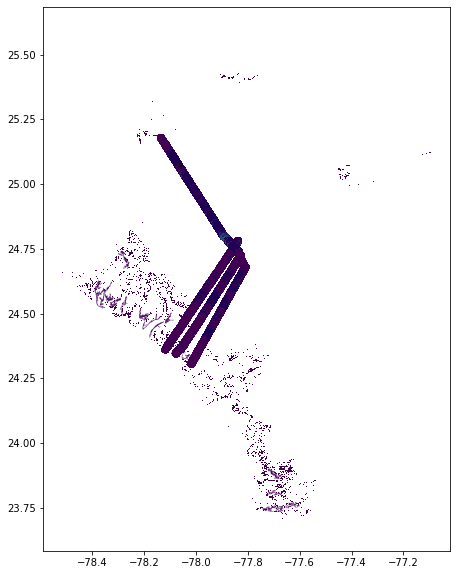

In [109]:
fig, ax = plt.subplots(figsize=(12,10), subplot_kw={'aspect':'equal'})
gmf.plot(column='gmf', ax=ax)
glihtchm_srtm_gdf.plot(column='z_m', ax=ax)
plt.show()

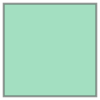

In [120]:
# Create a subset box for testing
from shapely.geometry import box
# subset_box = box(-78.1, 24.3, -77.9, 24.6)
subset_box = box(-78.1, 24.3, -78.0, 24.4)

subset_box

In [121]:
# Create a geodataframe for the subsetting box
subset_box_gdf = gpd.GeoDataFrame()
subset_box_gdf['geometry'] = None
subset_box_gdf.loc[0,'geometry'] = subset_box
subset_box_gdf.crs = {'init': 'epsg:4326'}
subset_box_gdf

,geometry
0,"POLYGON ((-78.00000 24.30000, -78.00000 24.400..."


In [122]:
# Subset the GLiHT points with the box
glihtchm_srtm_gdf_subset = glihtchm_srtm_gdf.cx[-78.1:-78.0, 24.3:24.4]

In [124]:
glihtchm_srtm_gdf_subset
# export to Geopackage
glihtchm_srtm_gdf_subset.to_file("gliht_srtm.gpkg", layer='glihtchm_srtm_hmax95_subset', driver="GPKG")

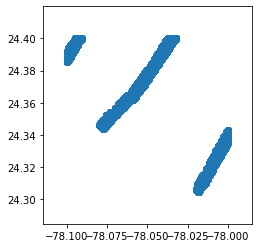

In [125]:
glihtchm_srtm_gdf_subset.plot()

In [127]:
glihtchm_srtm_gdf_subset

,z_m,x_utm17n,y_utm17n,geometry,srtm_m,srtm_id,hmax95,hmax95_id
52614044,0.0,800952.5,2701734.5,POINT (-78.03274 24.40000),5,41481243,-3.400000e+38,40990949
52614045,0.0,800953.5,2701734.5,POINT (-78.03273 24.40000),5,41481243,-3.400000e+38,40990949
52614046,0.0,800954.5,2701734.5,POINT (-78.03272 24.40000),5,41481243,-3.400000e+38,40990949
52614047,0.0,800955.5,2701734.5,POINT (-78.03271 24.40000),5,41481243,-3.400000e+38,40990949
52614048,0.0,800956.5,2701734.5,POINT (-78.03270 24.40000),5,41481243,-3.400000e+38,40990949
...,...,...,...,...,...,...,...,...
58146866,0.0,802646.5,2691223.5,POINT (-78.01828 24.30487),0,43944037,-3.400000e+38,44267460
58146867,0.0,802641.5,2691222.5,POINT (-78.01833 24.30486),0,43951238,-3.400000e+38,44267460
58146868,0.0,802644.5,2691221.5,POINT (-78.01830 24.30485),0,43951238,-3.400000e+38,44267460
58146869,0.0,802646.5,2691220.5,POINT (-78.01828 24.30484),0,43951238,-3.400000e+38,44267460


In [126]:
join1 = gpd.sjoin(glihtchm_srtm_gdf_subset, gmf, how="left")
join1.head

<bound method NDFrame.head of           z_m  x_utm17n   y_utm17n                    geometry  srtm_m  \
52614044  0.0  800952.5  2701734.5  POINT (-78.03274 24.40000)       5   
52614045  0.0  800953.5  2701734.5  POINT (-78.03273 24.40000)       5   
52614046  0.0  800954.5  2701734.5  POINT (-78.03272 24.40000)       5   
52614047  0.0  800955.5  2701734.5  POINT (-78.03271 24.40000)       5   
52614048  0.0  800956.5  2701734.5  POINT (-78.03270 24.40000)       5   
...       ...       ...        ...                         ...     ...   
58146866  0.0  802646.5  2691223.5  POINT (-78.01828 24.30487)       0   
58146867  0.0  802641.5  2691222.5  POINT (-78.01833 24.30486)       0   
58146868  0.0  802644.5  2691221.5  POINT (-78.01830 24.30485)       0   
58146869  0.0  802646.5  2691220.5  POINT (-78.01828 24.30484)       0   
58146870  0.0  802650.5  2691218.5  POINT (-78.01824 24.30482)       0   

           srtm_id        hmax95  hmax95_id  index_right  gmf  
52614044  4148124

In [129]:
join1 = join1.drop(columns='index_right')
join1

,z_m,x_utm17n,y_utm17n,geometry,srtm_m,srtm_id,hmax95,hmax95_id,gmf
52614044,0.0,800952.5,2701734.5,POINT (-78.03274 24.40000),5,41481243,-3.400000e+38,40990949,NaN
52614045,0.0,800953.5,2701734.5,POINT (-78.03273 24.40000),5,41481243,-3.400000e+38,40990949,NaN
52614046,0.0,800954.5,2701734.5,POINT (-78.03272 24.40000),5,41481243,-3.400000e+38,40990949,NaN
52614047,0.0,800955.5,2701734.5,POINT (-78.03271 24.40000),5,41481243,-3.400000e+38,40990949,NaN
52614048,0.0,800956.5,2701734.5,POINT (-78.03270 24.40000),5,41481243,-3.400000e+38,40990949,NaN
...,...,...,...,...,...,...,...,...,...
58146866,0.0,802646.5,2691223.5,POINT (-78.01828 24.30487),0,43944037,-3.400000e+38,44267460,NaN
58146867,0.0,802641.5,2691222.5,POINT (-78.01833 24.30486),0,43951238,-3.400000e+38,44267460,NaN
58146868,0.0,802644.5,2691221.5,POINT (-78.01830 24.30485),0,43951238,-3.400000e+38,44267460,NaN
58146869,0.0,802646.5,2691220.5,POINT (-78.01828 24.30484),0,43951238,-3.400000e+38,44267460,NaN


In [130]:
join2 = gpd.sjoin(join1, wam, how="left")
join2.head

<bound method NDFrame.head of           z_m  x_utm17n   y_utm17n                    geometry  srtm_m  \
52614044  0.0  800952.5  2701734.5  POINT (-78.03274 24.40000)       5   
52614045  0.0  800953.5  2701734.5  POINT (-78.03273 24.40000)       5   
52614046  0.0  800954.5  2701734.5  POINT (-78.03272 24.40000)       5   
52614047  0.0  800955.5  2701734.5  POINT (-78.03271 24.40000)       5   
52614048  0.0  800956.5  2701734.5  POINT (-78.03270 24.40000)       5   
...       ...       ...        ...                         ...     ...   
58146866  0.0  802646.5  2691223.5  POINT (-78.01828 24.30487)       0   
58146867  0.0  802641.5  2691222.5  POINT (-78.01833 24.30486)       0   
58146868  0.0  802644.5  2691221.5  POINT (-78.01830 24.30485)       0   
58146869  0.0  802646.5  2691220.5  POINT (-78.01828 24.30484)       0   
58146870  0.0  802650.5  2691218.5  POINT (-78.01824 24.30482)       0   

           srtm_id        hmax95  hmax95_id  gmf  index_right  wam  
52614044  41

In [131]:
join2 = join2.drop(columns='index_right')
join2

,z_m,x_utm17n,y_utm17n,geometry,srtm_m,srtm_id,hmax95,hmax95_id,gmf,wam
52614044,0.0,800952.5,2701734.5,POINT (-78.03274 24.40000),5,41481243,-3.400000e+38,40990949,NaN,NaN
52614045,0.0,800953.5,2701734.5,POINT (-78.03273 24.40000),5,41481243,-3.400000e+38,40990949,NaN,NaN
52614046,0.0,800954.5,2701734.5,POINT (-78.03272 24.40000),5,41481243,-3.400000e+38,40990949,NaN,NaN
52614047,0.0,800955.5,2701734.5,POINT (-78.03271 24.40000),5,41481243,-3.400000e+38,40990949,NaN,NaN
52614048,0.0,800956.5,2701734.5,POINT (-78.03270 24.40000),5,41481243,-3.400000e+38,40990949,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
58146866,0.0,802646.5,2691223.5,POINT (-78.01828 24.30487),0,43944037,-3.400000e+38,44267460,NaN,NaN
58146867,0.0,802641.5,2691222.5,POINT (-78.01833 24.30486),0,43951238,-3.400000e+38,44267460,NaN,NaN
58146868,0.0,802644.5,2691221.5,POINT (-78.01830 24.30485),0,43951238,-3.400000e+38,44267460,NaN,NaN
58146869,0.0,802646.5,2691220.5,POINT (-78.01828 24.30484),0,43951238,-3.400000e+38,44267460,NaN,NaN


In [159]:
join3 = gpd.sjoin(join2, gmw2015, how="left")
join3.head

<bound method NDFrame.head of           z_m  x_utm17n   y_utm17n                    geometry  srtm_m  \
52614044  0.0  800952.5  2701734.5  POINT (-78.03274 24.40000)       5   
52614045  0.0  800953.5  2701734.5  POINT (-78.03273 24.40000)       5   
52614046  0.0  800954.5  2701734.5  POINT (-78.03272 24.40000)       5   
52614047  0.0  800955.5  2701734.5  POINT (-78.03271 24.40000)       5   
52614048  0.0  800956.5  2701734.5  POINT (-78.03270 24.40000)       5   
...       ...       ...        ...                         ...     ...   
58146866  0.0  802646.5  2691223.5  POINT (-78.01828 24.30487)       0   
58146867  0.0  802641.5  2691222.5  POINT (-78.01833 24.30486)       0   
58146868  0.0  802644.5  2691221.5  POINT (-78.01830 24.30485)       0   
58146869  0.0  802646.5  2691220.5  POINT (-78.01828 24.30484)       0   
58146870  0.0  802650.5  2691218.5  POINT (-78.01824 24.30482)       0   

           srtm_id        hmax95  hmax95_id  gmf  wam  index_right  gmw2015  
526

In [160]:
join3 = join3.drop(columns='index_right')
join3

,z_m,x_utm17n,y_utm17n,geometry,srtm_m,srtm_id,hmax95,hmax95_id,gmf,wam,gmw2015
52614044,0.0,800952.5,2701734.5,POINT (-78.03274 24.40000),5,41481243,-3.400000e+38,40990949,NaN,NaN,1.0
52614045,0.0,800953.5,2701734.5,POINT (-78.03273 24.40000),5,41481243,-3.400000e+38,40990949,NaN,NaN,1.0
52614046,0.0,800954.5,2701734.5,POINT (-78.03272 24.40000),5,41481243,-3.400000e+38,40990949,NaN,NaN,1.0
52614047,0.0,800955.5,2701734.5,POINT (-78.03271 24.40000),5,41481243,-3.400000e+38,40990949,NaN,NaN,1.0
52614048,0.0,800956.5,2701734.5,POINT (-78.03270 24.40000),5,41481243,-3.400000e+38,40990949,NaN,NaN,1.0
...,...,...,...,...,...,...,...,...,...,...,...
58146866,0.0,802646.5,2691223.5,POINT (-78.01828 24.30487),0,43944037,-3.400000e+38,44267460,NaN,NaN,NaN
58146867,0.0,802641.5,2691222.5,POINT (-78.01833 24.30486),0,43951238,-3.400000e+38,44267460,NaN,NaN,NaN
58146868,0.0,802644.5,2691221.5,POINT (-78.01830 24.30485),0,43951238,-3.400000e+38,44267460,NaN,NaN,NaN
58146869,0.0,802646.5,2691220.5,POINT (-78.01828 24.30484),0,43951238,-3.400000e+38,44267460,NaN,NaN,NaN


In [161]:
join3.columns

Index(['z_m', 'x_utm17n', 'y_utm17n', 'geometry', 'srtm_m', 'srtm_id',
       'hmax95', 'hmax95_id', 'gmf', 'wam', 'gmw2015'],
      dtype='object')

In [162]:
join3.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 3134273 entries, 52614044 to 58146870
Data columns (total 11 columns):
z_m          float64
x_utm17n     float64
y_utm17n     float64
geometry     geometry
srtm_m       int16
srtm_id      uint32
hmax95       float32
hmax95_id    uint32
gmf          float64
wam          float64
gmw2015      float64
dtypes: float32(1), float64(6), geometry(1), int16(1), uint32(2)
memory usage: 233.1 MB


In [163]:
glihtchm_srtm_gdf_subset.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 3134273 entries, 52614044 to 58146870
Data columns (total 8 columns):
z_m          float64
x_utm17n     float64
y_utm17n     float64
geometry     geometry
srtm_m       int16
srtm_id      uint32
hmax95       float32
hmax95_id    uint32
dtypes: float32(1), float64(3), geometry(1), int16(1), uint32(2)
memory usage: 161.4 MB


In [164]:
gmf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 4746 entries, 0 to 4745
Data columns (total 2 columns):
gmf         4746 non-null int64
geometry    4746 non-null geometry
dtypes: geometry(1), int64(1)
memory usage: 74.3 KB


In [165]:
wam.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 3 entries, 0 to 2
Data columns (total 2 columns):
wam         3 non-null int64
geometry    3 non-null geometry
dtypes: geometry(1), int64(1)
memory usage: 176.0 bytes


In [166]:
gmw2015.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 9709 entries, 0 to 9708
Data columns (total 2 columns):
gmw2015     9709 non-null int8
geometry    9709 non-null geometry
dtypes: geometry(1), int8(1)
memory usage: 85.5 KB


In [143]:
# export to Geopackage
# join3.to_file("gliht_srtm.gpkg", layer='glihtchm_srtm_hmax95_mangroves_subset', driver="GPKG")

In [167]:
join3.describe()

,z_m,x_utm17n,y_utm17n,srtm_m,srtm_id,hmax95,hmax95_id,gmf,wam,gmw2015
count,3.134273e+06,3.134273e+06,3.134273e+06,3.134273e+06,3.134273e+06,3.134273e+06,3.134273e+06,822711.0,5471.0,761119.0
mean,2.623890e-01,7.999753e+05,2.697557e+06,3.839834e+00,4.245318e+07,-inf,4.228360e+07,1.0,1.0,1.0
std,7.590770e-01,2.678739e+03,2.967035e+03,2.757649e+00,7.021960e+05,inf,9.311020e+05,0.0,0.0,0.0
min,-1.136868e-13,7.941465e+05,2.691218e+06,-1.400000e+01,4.148102e+07,-3.400000e+38,4.099071e+07,1.0,1.0,1.0
25%,0.000000e+00,7.982985e+05,2.694872e+06,2.000000e+00,4.183405e+07,-3.400000e+38,4.145897e+07,1.0,1.0,1.0
50%,0.000000e+00,7.996575e+05,2.697980e+06,4.000000e+00,4.234528e+07,-3.400000e+38,4.214302e+07,1.0,1.0,1.0
75%,0.000000e+00,8.027565e+05,2.700190e+06,6.000000e+00,4.310158e+07,1.697000e+00,4.314417e+07,1.0,1.0,1.0
max,1.115000e+01,8.044305e+05,2.701734e+06,2.200000e+01,4.395124e+07,1.357600e+01,4.426746e+07,1.0,1.0,1.0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f84696b2898>]],
      dtype=object)

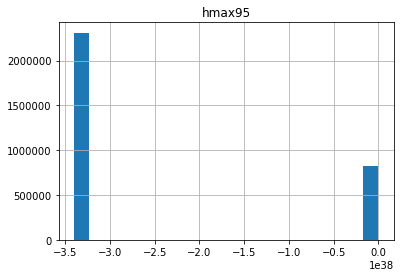

In [168]:
join3.hist(column='hmax95', bins=20)

In [169]:
# Change No data values in hmax95 column to NaN
# This does not work -- not sure why,  have to use > 0 instead
# hmax95_nodata = join3.loc[join3['hmax95'] == -3.4e+38, 'hmax95'] = np.nan

### Filter Data based on GLiHT Height > 0 and presence of mangroves in various data layers

In [191]:
glihtchm_srtm_gdf_subset_mangroves = join3.copy()

In [192]:
glihtchm_srtm_gdf_subset_mangroves.describe()

,z_m,x_utm17n,y_utm17n,srtm_m,srtm_id,hmax95,hmax95_id,gmf,wam,gmw2015
count,3.134273e+06,3.134273e+06,3.134273e+06,3.134273e+06,3.134273e+06,3.134273e+06,3.134273e+06,822711.0,5471.0,761119.0
mean,2.623890e-01,7.999753e+05,2.697557e+06,3.839834e+00,4.245318e+07,-inf,4.228360e+07,1.0,1.0,1.0
std,7.590770e-01,2.678739e+03,2.967035e+03,2.757649e+00,7.021960e+05,inf,9.311020e+05,0.0,0.0,0.0
min,-1.136868e-13,7.941465e+05,2.691218e+06,-1.400000e+01,4.148102e+07,-3.400000e+38,4.099071e+07,1.0,1.0,1.0
25%,0.000000e+00,7.982985e+05,2.694872e+06,2.000000e+00,4.183405e+07,-3.400000e+38,4.145897e+07,1.0,1.0,1.0
50%,0.000000e+00,7.996575e+05,2.697980e+06,4.000000e+00,4.234528e+07,-3.400000e+38,4.214302e+07,1.0,1.0,1.0
75%,0.000000e+00,8.027565e+05,2.700190e+06,6.000000e+00,4.310158e+07,1.697000e+00,4.314417e+07,1.0,1.0,1.0
max,1.115000e+01,8.044305e+05,2.701734e+06,2.200000e+01,4.395124e+07,1.357600e+01,4.426746e+07,1.0,1.0,1.0


In [195]:
glihtchm_srtm_gdf_subset_mangroves.loc[glihtchm_srtm_gdf_subset_mangroves['hmax95'] < 0, 'hmax95'] = np.nan

In [197]:
glihtchm_srtm_gdf_subset_mangroves

,z_m,x_utm17n,y_utm17n,geometry,srtm_m,srtm_id,hmax95,hmax95_id,gmf,wam,gmw2015
52614044,0.0,800952.5,2701734.5,POINT (-78.03274 24.40000),5,41481243,NaN,40990949,NaN,NaN,1.0
52614045,0.0,800953.5,2701734.5,POINT (-78.03273 24.40000),5,41481243,NaN,40990949,NaN,NaN,1.0
52614046,0.0,800954.5,2701734.5,POINT (-78.03272 24.40000),5,41481243,NaN,40990949,NaN,NaN,1.0
52614047,0.0,800955.5,2701734.5,POINT (-78.03271 24.40000),5,41481243,NaN,40990949,NaN,NaN,1.0
52614048,0.0,800956.5,2701734.5,POINT (-78.03270 24.40000),5,41481243,NaN,40990949,NaN,NaN,1.0
...,...,...,...,...,...,...,...,...,...,...,...
58146866,0.0,802646.5,2691223.5,POINT (-78.01828 24.30487),0,43944037,NaN,44267460,NaN,NaN,NaN
58146867,0.0,802641.5,2691222.5,POINT (-78.01833 24.30486),0,43951238,NaN,44267460,NaN,NaN,NaN
58146868,0.0,802644.5,2691221.5,POINT (-78.01830 24.30485),0,43951238,NaN,44267460,NaN,NaN,NaN
58146869,0.0,802646.5,2691220.5,POINT (-78.01828 24.30484),0,43951238,NaN,44267460,NaN,NaN,NaN


In [201]:
glihtchm_srtm_gdf_subset_mangroves_gt0 = glihtchm_srtm_gdf_subset_mangroves[glihtchm_srtm_gdf_subset_mangroves['z_m'] > 0]
glihtchm_srtm_gdf_subset_mangroves_gt0

,z_m,x_utm17n,y_utm17n,geometry,srtm_m,srtm_id,hmax95,hmax95_id,gmf,wam,gmw2015
52615247,0.85,800915.5,2701733.5,POINT (-78.03310 24.40000),5,41481242,NaN,40990948,1.0,NaN,1.0
52615248,1.22,800916.5,2701733.5,POINT (-78.03309 24.40000),5,41481242,NaN,40990948,1.0,NaN,1.0
52615250,1.22,800918.5,2701733.5,POINT (-78.03307 24.40000),5,41481242,NaN,40990948,1.0,NaN,1.0
52615251,0.80,800919.5,2701733.5,POINT (-78.03306 24.40000),5,41481242,NaN,40990948,1.0,NaN,1.0
52615255,0.61,800923.5,2701733.5,POINT (-78.03302 24.40000),5,41481242,NaN,40990948,NaN,NaN,1.0
...,...,...,...,...,...,...,...,...,...,...,...
58087855,0.40,802808.5,2691685.5,POINT (-78.01658 24.30900),0,43843229,NaN,44123446,NaN,NaN,NaN
58087860,1.07,802813.5,2691685.5,POINT (-78.01654 24.30900),0,43843229,NaN,44123446,NaN,NaN,NaN
58087861,0.55,802814.5,2691685.5,POINT (-78.01653 24.30900),0,43843230,NaN,44123446,NaN,NaN,NaN
58087864,0.28,802817.5,2691685.5,POINT (-78.01650 24.30900),0,43843230,NaN,44123446,NaN,NaN,NaN


In [203]:
glihtchm_srtm_gdf_subset_mangroves_gt0_gmf = glihtchm_srtm_gdf_subset_mangroves_gt0[glihtchm_srtm_gdf_subset_mangroves_gt0['gmf'] == 1]
glihtchm_srtm_gdf_subset_mangroves_gt0_gmf

,z_m,x_utm17n,y_utm17n,geometry,srtm_m,srtm_id,hmax95,hmax95_id,gmf,wam,gmw2015
52615247,0.85,800915.5,2701733.5,POINT (-78.03310 24.40000),5,41481242,NaN,40990948,1.0,NaN,1.0
52615248,1.22,800916.5,2701733.5,POINT (-78.03309 24.40000),5,41481242,NaN,40990948,1.0,NaN,1.0
52615250,1.22,800918.5,2701733.5,POINT (-78.03307 24.40000),5,41481242,NaN,40990948,1.0,NaN,1.0
52615251,0.80,800919.5,2701733.5,POINT (-78.03306 24.40000),5,41481242,NaN,40990948,1.0,NaN,1.0
52616433,1.85,800860.5,2701732.5,POINT (-78.03364 24.40000),5,41481240,8.485,40990946,1.0,NaN,1.0
...,...,...,...,...,...,...,...,...,...,...,...
57667442,0.48,803953.5,2694143.5,POINT (-78.00479 24.33095),2,43274393,NaN,43374588,1.0,NaN,NaN
57667446,0.98,803957.5,2694143.5,POINT (-78.00476 24.33095),2,43274393,NaN,43374588,1.0,NaN,NaN
57667454,0.10,803965.5,2694143.5,POINT (-78.00468 24.33095),2,43274393,NaN,43374588,1.0,NaN,NaN
57667793,1.29,803895.5,2694142.5,POINT (-78.00537 24.33095),4,43274391,NaN,43374585,1.0,NaN,NaN


In [204]:
glihtchm_srtm_gdf_subset_mangroves_gt0_wam  = glihtchm_srtm_gdf_subset_mangroves_gt0[glihtchm_srtm_gdf_subset_mangroves_gt0['wam'] == 1]
glihtchm_srtm_gdf_subset_mangroves_gt0_wam

,z_m,x_utm17n,y_utm17n,geometry,srtm_m,srtm_id,hmax95,hmax95_id,gmf,wam,gmw2015
57071232,0.29,796750.5,2696029.5,POINT (-78.07531 24.34935),3,42791672,NaN,42733427,NaN,1.0,NaN
57074029,0.30,796784.5,2696021.5,POINT (-78.07498 24.34927),4,42798874,NaN,42740629,NaN,1.0,NaN
57074759,0.35,796681.5,2696019.5,POINT (-78.07599 24.34927),7,42798870,NaN,42740625,NaN,1.0,NaN
57075491,0.16,796695.5,2696017.5,POINT (-78.07585 24.34925),6,42798871,NaN,42740626,NaN,1.0,NaN
57075888,0.24,796779.5,2696016.5,POINT (-78.07503 24.34922),4,42798874,NaN,42740629,NaN,1.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...
57103031,0.48,796885.5,2695926.5,POINT (-78.07400 24.34839),7,42820481,NaN,42769437,NaN,1.0,NaN
57103598,0.31,796487.5,2695923.5,POINT (-78.07792 24.34844),1,42820466,NaN,42769422,NaN,1.0,NaN
57103599,0.39,796503.5,2695923.5,POINT (-78.07776 24.34844),3,42820467,NaN,42769423,NaN,1.0,NaN
57104896,0.24,796470.5,2695916.5,POINT (-78.07809 24.34838),1,42820466,NaN,42769422,NaN,1.0,NaN


In [205]:
glihtchm_srtm_gdf_subset_mangroves_gt0_gmw2015  = glihtchm_srtm_gdf_subset_mangroves_gt0[glihtchm_srtm_gdf_subset_mangroves_gt0['gmw2015'] == 1]
glihtchm_srtm_gdf_subset_mangroves_gt0_gmw2015

,z_m,x_utm17n,y_utm17n,geometry,srtm_m,srtm_id,hmax95,hmax95_id,gmf,wam,gmw2015
52615247,0.85,800915.5,2701733.5,POINT (-78.03310 24.40000),5,41481242,NaN,40990948,1.0,NaN,1.0
52615248,1.22,800916.5,2701733.5,POINT (-78.03309 24.40000),5,41481242,NaN,40990948,1.0,NaN,1.0
52615250,1.22,800918.5,2701733.5,POINT (-78.03307 24.40000),5,41481242,NaN,40990948,1.0,NaN,1.0
52615251,0.80,800919.5,2701733.5,POINT (-78.03306 24.40000),5,41481242,NaN,40990948,1.0,NaN,1.0
52615255,0.61,800923.5,2701733.5,POINT (-78.03302 24.40000),5,41481242,NaN,40990948,NaN,NaN,1.0
...,...,...,...,...,...,...,...,...,...,...,...
57996449,0.83,803058.5,2691911.5,POINT (-78.01408 24.31099),4,43785630,NaN,44058647,NaN,NaN,1.0
57996450,1.58,803059.5,2691911.5,POINT (-78.01407 24.31099),4,43785630,NaN,44058647,NaN,NaN,1.0
57996838,1.25,803057.5,2691910.5,POINT (-78.01409 24.31098),4,43785630,NaN,44058647,NaN,NaN,1.0
57996839,0.83,803058.5,2691910.5,POINT (-78.01408 24.31098),4,43785630,NaN,44058647,NaN,NaN,1.0


### Linear Regressions of SRTM versus GLiHT

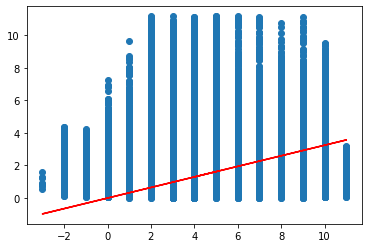

R squared: -0.25697821968964973
intercept: 0.0
slope: [[0.32456877]]
RMSE: 1.3403019201749764


In [212]:
# https://towardsdatascience.com/linear-regression-in-6-lines-of-python-5e1d0cd05b8d
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Giri, Global Mangrove Forests
linear_regressor = LinearRegression(fit_intercept=False)  # create object for the class
X = glihtchm_srtm_gdf_subset_mangroves_gt0_gmf['srtm_m'].values.reshape(-1, 1)
Y = glihtchm_srtm_gdf_subset_mangroves_gt0_gmf['z_m'].values.reshape(-1, 1)
linear_regressor.fit(X, Y)  # perform linear regression
Y_pred = linear_regressor.predict(X)  # make predictions

plt.scatter(X, Y)
plt.plot(X, Y_pred, color='red')
plt.show()

r_sq = linear_regressor.score(X, Y)
print("R squared:", r_sq)
intercept = linear_regressor.intercept_
print("intercept:", intercept)
slope = linear_regressor.coef_
print("slope:", slope)
rmse = np.sqrt(mean_squared_error(y_true=Y, y_pred=Y_pred))
print("RMSE:", rmse)

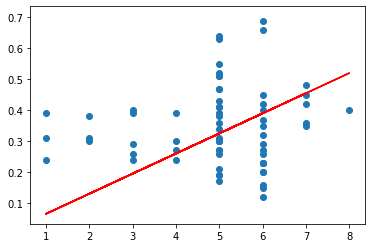

R squared: -0.4810950671617118
intercept: 0.0
slope: [[0.0650279]]
RMSE: 0.15116949909782906


In [213]:
# Spalding, World Atlas of Mangroves
linear_regressor = LinearRegression(fit_intercept=False)  # create object for the class
X = glihtchm_srtm_gdf_subset_mangroves_gt0_wam['srtm_m'].values.reshape(-1, 1)
Y = glihtchm_srtm_gdf_subset_mangroves_gt0_wam['z_m'].values.reshape(-1, 1)
linear_regressor.fit(X, Y)  # perform linear regression
Y_pred = linear_regressor.predict(X)  # make predictions

plt.scatter(X, Y)
plt.plot(X, Y_pred, color='red')
plt.show()

r_sq = linear_regressor.score(X, Y)
print("R squared:", r_sq)
intercept = linear_regressor.intercept_
print("intercept:", intercept)
slope = linear_regressor.coef_
print("slope:", slope)
rmse = np.sqrt(mean_squared_error(y_true=Y, y_pred=Y_pred))
print("RMSE:", rmse)

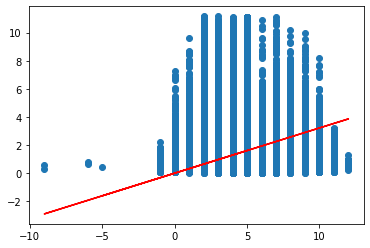

R squared: -0.3197208164398819
intercept: 0.0
slope: [[0.32184149]]
RMSE: 1.278914299716339


In [214]:
# Bunting, Global Mangrove Watch 2015
linear_regressor = LinearRegression(fit_intercept=False)  # create object for the class
X = glihtchm_srtm_gdf_subset_mangroves_gt0_gmw2015['srtm_m'].values.reshape(-1, 1)
Y = glihtchm_srtm_gdf_subset_mangroves_gt0_gmw2015['z_m'].values.reshape(-1, 1)
linear_regressor.fit(X, Y)  # perform linear regression
Y_pred = linear_regressor.predict(X)  # make predictions

plt.scatter(X, Y)
plt.plot(X, Y_pred, color='red')
plt.show()

r_sq = linear_regressor.score(X, Y)
print("R squared:", r_sq)
intercept = linear_regressor.intercept_
print("intercept:", intercept)
slope = linear_regressor.coef_
print("slope:", slope)
rmse = np.sqrt(mean_squared_error(y_true=Y, y_pred=Y_pred))
print("RMSE:", rmse)

In [4]:
# Look at stats for CHM compared to max heights from Simard
# Group by hmax_id and compare max height to various stats from GLiHT
# glihtchm_srtm_gdf_subset_mangroves_gt0_hmax = glihtchm_srtm_gdf_subset_mangroves[(glihtchm_srtm_gdf_subset_mangroves['z_m'] > 0) & (glihtchm_srtm_gdf_subset_mangroves['hmax95'] > 0)]
glihtchm_srtm_gdf_subset_mangroves_gt0

NameError: name 'glihtchm_srtm_gdf_subset_mangroves_gt0' is not defined

### Joins with Full GLiHT data set

In [216]:
# %%time
# join11 = gpd.sjoin(glihtchm_srtm_gdf, gmf, how="left")
# join11 = join11.drop(columns='index_right')
# print(join11.head)

<bound method NDFrame.head of           z_m  x_utm17n   y_utm17n                    geometry  srtm_m  \
0         0.0  788785.5  2787858.5  POINT (-78.13478 25.17915)       0   
1         0.0  788781.5  2787857.5  POINT (-78.13482 25.17914)       0   
2         0.0  788784.5  2787857.5  POINT (-78.13479 25.17914)       0   
3         0.0  788776.5  2787856.5  POINT (-78.13487 25.17913)       0   
4         0.0  788778.5  2787856.5  POINT (-78.13485 25.17913)       0   
...       ...       ...        ...                         ...     ...   
58146866  0.0  802646.5  2691223.5  POINT (-78.01828 24.30487)       0   
58146867  0.0  802641.5  2691222.5  POINT (-78.01833 24.30486)       0   
58146868  0.0  802644.5  2691221.5  POINT (-78.01830 24.30485)       0   
58146869  0.0  802646.5  2691220.5  POINT (-78.01828 24.30484)       0   
58146870  0.0  802650.5  2691218.5  POINT (-78.01824 24.30482)       0   

           srtm_id        hmax95  hmax95_id  gmf  
0         21282071 -3.400000e+

In [220]:
# %%time
# join12 = gpd.sjoin(join11, wam, how="left")
# join12 = join12.drop(columns='index_right')
# join12.head

CPU times: user 6min 59s, sys: 9min 56s, total: 16min 56s
Wall time: 22min 30s


<bound method NDFrame.head of           z_m  x_utm17n   y_utm17n                    geometry  srtm_m  \
0         0.0  788785.5  2787858.5  POINT (-78.13478 25.17915)       0   
1         0.0  788781.5  2787857.5  POINT (-78.13482 25.17914)       0   
2         0.0  788784.5  2787857.5  POINT (-78.13479 25.17914)       0   
3         0.0  788776.5  2787856.5  POINT (-78.13487 25.17913)       0   
4         0.0  788778.5  2787856.5  POINT (-78.13485 25.17913)       0   
...       ...       ...        ...                         ...     ...   
58146866  0.0  802646.5  2691223.5  POINT (-78.01828 24.30487)       0   
58146867  0.0  802641.5  2691222.5  POINT (-78.01833 24.30486)       0   
58146868  0.0  802644.5  2691221.5  POINT (-78.01830 24.30485)       0   
58146869  0.0  802646.5  2691220.5  POINT (-78.01828 24.30484)       0   
58146870  0.0  802650.5  2691218.5  POINT (-78.01824 24.30482)       0   

           srtm_id        hmax95  hmax95_id  gmf  wam  
0         21282071 -3.400

In [231]:
# # export to Geopackage
# # %%time
# join12.to_file("gliht_srtm.gpkg", layer='glihtchm_srtm_hmax95_mangroves', driver="GPKG")